In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BuildTardisData import linear_data
from BacktestStrategy import backtest_strategy

### Lags and delays for optimal accuracy

In [2]:
l, d = 1, 2

### Backtesting results for past 3 months data

In [3]:

def read_datasets():
    
    # Get all file names in the directory
    quotes, trades = os.listdir("D:\Quotes"), os.listdir("D:\Trades")
    
    # Loop through each file
    for quote, trade in zip(quotes, trades):
        
        file_path_q = os.path.join("D:\Quotes", quote)
        file_path_t = os.path.join("D:\Trades", trade)
            
        # Read the dataset using pandas
        df1 = pd.read_csv(file_path_q)
        df2 = pd.read_csv(file_path_t)
    
        # Yield combined dataset
        yield linear_data(df1, df2, l=l, d=d), quote[23:33]


We will be using one day's data to train the model and predict the next day.

**Assumptions:**
1. Initial Portfolio Value = $30,000
2. This includes the price to take one position at day open plus maintenance margin
3. Trade price equals Best Bid or Best ask depending on the position taken

### Profits for each trading day (Before Transaction Costs & Using Original MPB Formula) 

In [4]:
Profits_dict = {}
vol_dict = {}
datasets = read_datasets()
train, date = next(datasets)
for i in range(1,122):
    test, date = next(datasets)
    df = backtest_strategy(train, test, threshold=0.1, l=l, optimise=True)
    train = test
    Profits_dict[date] = sum(df["Trade Cost"])
    vol_dict[date] = df.iloc[-1,3]
    if i%50 == 0:
        print(Profits_dict)

{'2022-12-29': 8153.899999999638, '2022-12-30': 5902.299999999803, '2022-12-31': 3345.699999999986, '2023-01-01': 1291.5999999999221, '2023-01-02': 2622.7000000001535, '2023-01-03': 5372.199999999892, '2023-01-04': 7646.599999999718, '2023-01-05': 5029.900000000136, '2023-01-06': 4249.499999999749, '2023-01-07': 1242.199999999928, '2023-01-08': 14.999999999992724, '2023-01-09': 12187.899999999874, '2023-01-10': 9096.499999999996, '2023-01-11': 11134.399999999809, '2023-01-12': 56364.99999999955, '2023-01-13': 62634.799999999595, '2023-01-14': 110002.10000001335, '2023-01-15': 55206.20000000094, '2023-01-16': 77779.6000000007, '2023-01-17': 66659.70000000214, '2023-01-18': 90382.10000000155, '2023-01-19': 36062.79999999763, '2023-01-20': 54396.0999999991, '2023-01-21': 80079.3000000015, '2023-01-22': 57389.19999999926, '2023-01-23': 62843.40000000057, '2023-01-24': 58290.00000000037, '2023-01-25': 77288.6000000017, '2023-01-26': 60095.40000000298, '2023-01-27': 57167.0999999988, '2023-0

In [5]:
profits_df = pd.DataFrame(Profits_dict.values(), Profits_dict.keys(), columns=["Profit"])
profits_df

,Profit
2022-12-29,8153.9
2022-12-30,5902.3
2022-12-31,3345.7
2023-01-01,1291.6
2023-01-02,2622.7
...,...
2023-04-24,59612.7
2023-04-25,51771.1
2023-04-26,102644.9
2023-04-27,113631.0


In [6]:
vol_df = pd.DataFrame(vol_dict.values(), vol_dict.keys(), columns=["Volume"])
vol_df

,Volume
2022-12-29,11820
2022-12-30,4594
2022-12-31,3974
2023-01-01,848
2023-01-02,1966
...,...
2023-04-24,70358
2023-04-25,62688
2023-04-26,120562
2023-04-27,142894


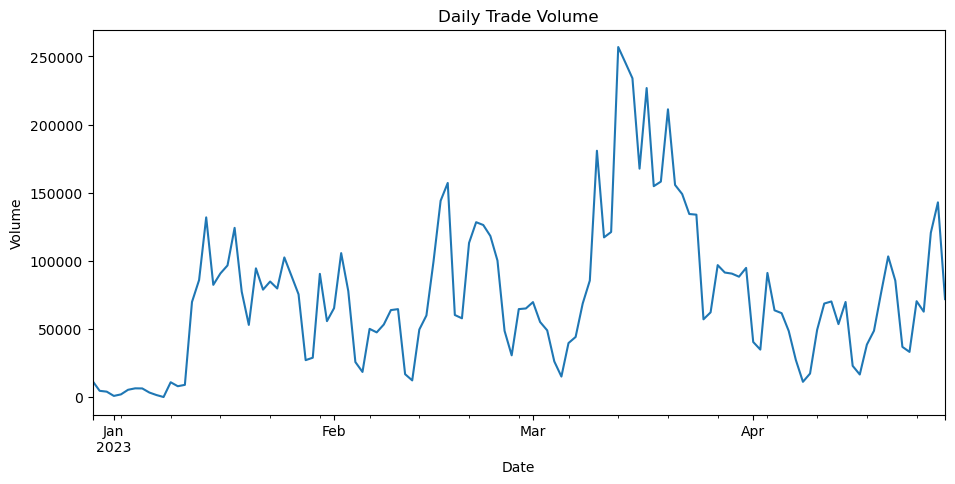

In [7]:
vol_df.index = pd.to_datetime(vol_df.index)
plt.title('Daily Trade Volume')
vol_df["Volume"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

### Portfolio Profit and Returns Graph

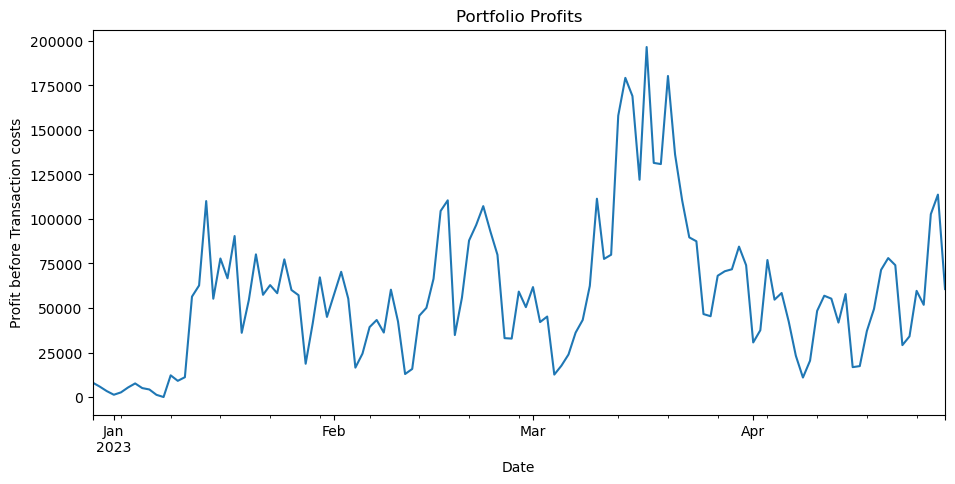

In [8]:
profits_df.index = pd.to_datetime(profits_df.index)
plt.title('Portfolio Profits')
profits_df["Profit"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Profit before Transaction costs')
plt.show()

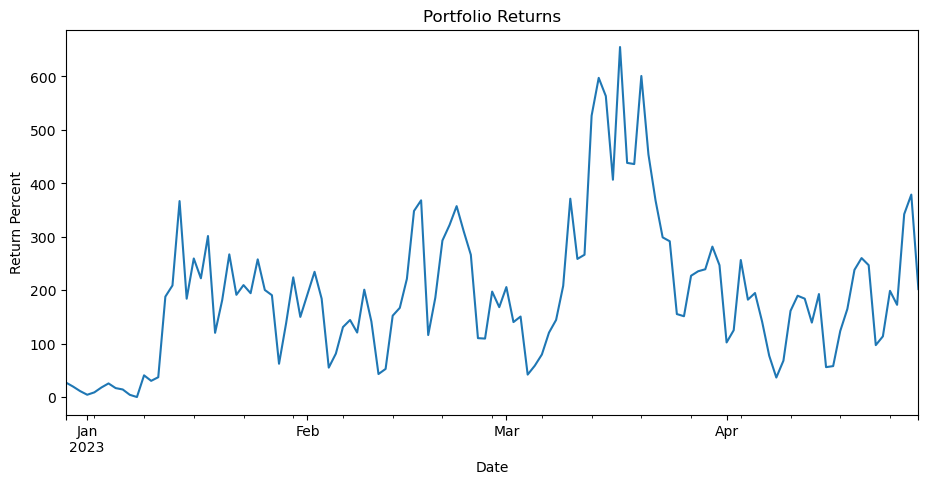

In [9]:
profits_df["Return Percent"] = (profits_df["Profit"]/30_000)*100
plt.title('Portfolio Returns')
profits_df["Return Percent"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Return Percent')
plt.show()

### Sharpe Ratio and Daily Drawdown

In [12]:
def calculate_sharpe_ratio(returns_data, risk_free_rate):
    
    # Calculate portfolio returns and volatility
    portfolio_returns = np.mean(returns_data)
    portfolio_volatility = np.std(returns_data)

    # Calculate excess returns
    excess_returns = portfolio_returns - risk_free_rate

    # Calculate Sharpe ratio
    sharpe_ratio = excess_returns / portfolio_volatility

    return sharpe_ratio

In [11]:
display("Sharpe Ratio of the Portfolio is:", calculate_sharpe_ratio(profits_df["Return Percent"], 4.5))

'Sharpe Ratio of the Portfolio is:'

1.4243710094328985

Although, the strategy seems quite successfull, there is a lot of volatilty in the returns, the returns range from less than 5 percent to greater than 500, and therefore the sharpe ratio is rather low.

In [12]:
np.std(profits_df["Return Percent"])

133.5700472491847

### Given the dataset, I have chosen a rolling window of 7 days to calculate the daily drawdowns.

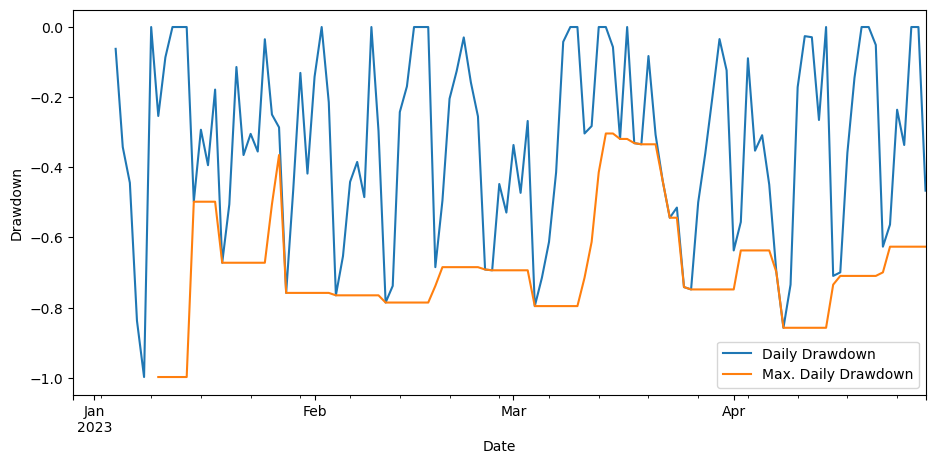

In [13]:
# We are going to use a trailing 1 trading day window
window = 7

# Calculate the max drawdown in the past window days for each day in the series.
Roll_Max = profits_df["Return Percent"].rolling(window).max()
Daily_Drawdown = profits_df["Return Percent"]/Roll_Max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown = Daily_Drawdown.rolling(window).min()

# Plot the results
Daily_Drawdown.plot(figsize=(11,5), label='Daily Drawdown')
Max_Daily_Drawdown.plot(figsize=(11,5), label='Max. Daily Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()

### Profits for each trading day (Before Transaction Costs & Using Updated MPB Formula) 

In [3]:
def read_datasets():
    
    # Get all file names in the directory
    quotes, trades = os.listdir("D:\Quotes"), os.listdir("D:\Trades")
    
    # Loop through each file
    for quote, trade in zip(quotes, trades):
        
        file_path_q = os.path.join("D:\Quotes", quote)
        file_path_t = os.path.join("D:\Trades", trade)
            
        # Read the dataset using pandas
        df1 = pd.read_csv(file_path_q)
        df2 = pd.read_csv(file_path_t)
    
        # Yield combined dataset
        yield linear_data(df1, df2, l=l, d=d, mpb='updated'), quote[23:33]

In [5]:
Profits_dict = {}
vol_dict = {}
datasets = read_datasets()
train, date = next(datasets)
for i in range(1,122):
    test, date = next(datasets)
    df = backtest_strategy(train, test, threshold=0.1, l=l, optimise=True)
    train = test
    Profits_dict[date] = sum(df["Trade Cost"])
    vol_dict[date] = df.iloc[-1,3]
    if i%50 == 0:
        print(Profits_dict)

{'2022-12-29': 8168.999999999487, '2022-12-30': 6419.5999999998385, '2022-12-31': 3385.4999999999527, '2023-01-01': 1456.8999999999469, '2023-01-02': 3044.200000000037, '2023-01-03': 5340.699999999921, '2023-01-04': 8420.799999999803, '2023-01-05': 5205.500000000142, '2023-01-06': 4798.6999999999825, '2023-01-07': 1349.599999999973, '2023-01-08': 283.89999999998327, '2023-01-09': 12512.199999999786, '2023-01-10': 9342.89999999999, '2023-01-11': 11636.799999999737, '2023-01-12': 57465.99999999984, '2023-01-13': 64231.39999999992, '2023-01-14': 115825.10000001769, '2023-01-15': 57318.6000000004, '2023-01-16': 80809.4000000003, '2023-01-17': 68858.70000000257, '2023-01-18': 95083.40000000285, '2023-01-19': 36532.19999999777, '2023-01-20': 55828.49999999872, '2023-01-21': 83819.1000000016, '2023-01-22': 61404.59999999975, '2023-01-23': 65956.60000000123, '2023-01-24': 60146.8000000009, '2023-01-25': 80346.70000000193, '2023-01-26': 61888.20000000369, '2023-01-27': 58766.29999999999, '2023-

In [6]:
profits_df = pd.DataFrame(Profits_dict.values(), Profits_dict.keys(), columns=["Profit"])
profits_df

,Profit
2022-12-29,8169.0
2022-12-30,6419.6
2022-12-31,3385.5
2023-01-01,1456.9
2023-01-02,3044.2
...,...
2023-04-24,62064.5
2023-04-25,52984.8
2023-04-26,107893.0
2023-04-27,119054.2


In [7]:
vol_df = pd.DataFrame(vol_dict.values(), vol_dict.keys(), columns=["Volume"])
vol_df

,Volume
2022-12-29,11568
2022-12-30,5278
2022-12-31,4098
2023-01-01,986
2023-01-02,2178
...,...
2023-04-24,69548
2023-04-25,62766
2023-04-26,119434
2023-04-27,142310


### Portfolio Profit and Returns Graph

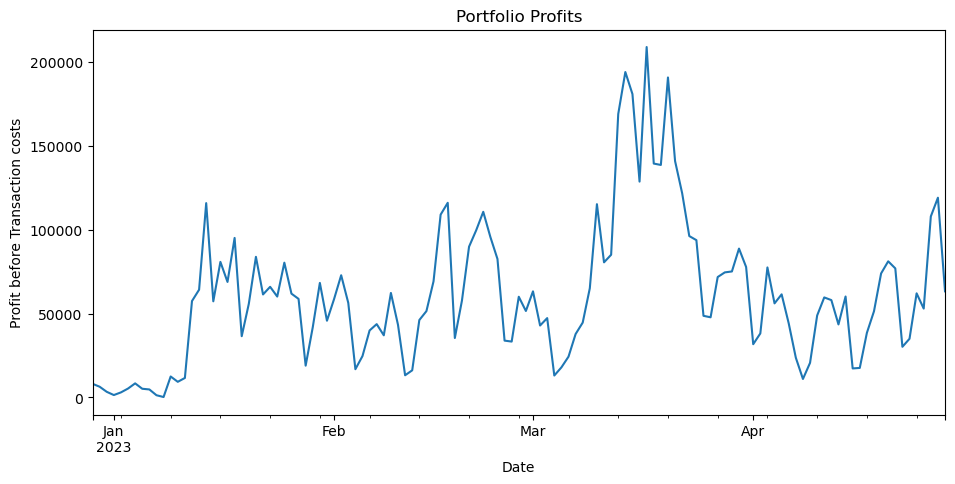

In [8]:
profits_df.index = pd.to_datetime(profits_df.index)
plt.title('Portfolio Profits')
profits_df["Profit"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Profit before Transaction costs')
plt.show()

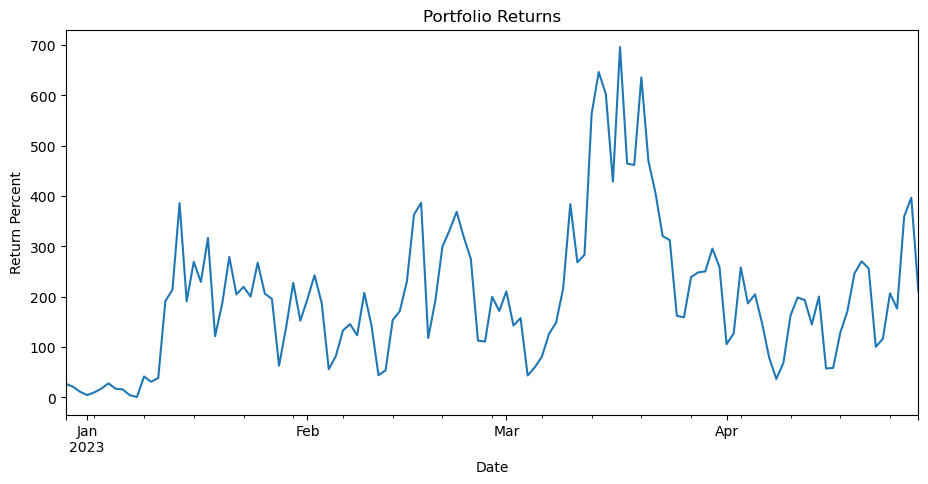

In [9]:
profits_df["Return Percent"] = (profits_df["Profit"]/30_000)*100
plt.title('Portfolio Returns')
profits_df["Return Percent"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Return Percent')
plt.show()

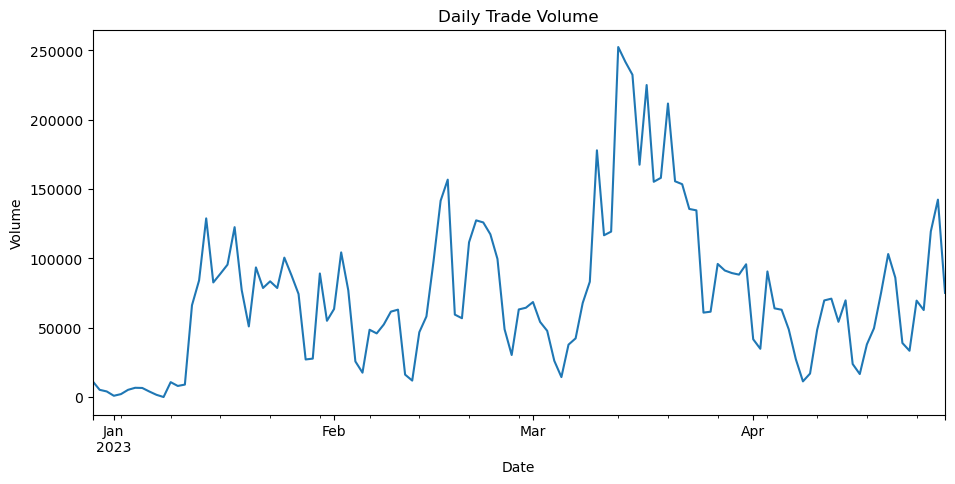

In [10]:
vol_df.index = pd.to_datetime(vol_df.index)
plt.title('Daily Trade Volume')
vol_df["Volume"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

### Share Ratio and Daily Drawdown

In [13]:
display("Sharpe Ratio of the Portfolio is:", calculate_sharpe_ratio(profits_df["Return Percent"], 4.5))

'Sharpe Ratio of the Portfolio is:'

1.3984160754871042

In [14]:
np.std(profits_df["Return Percent"])

142.04316960634503

No improvements here!!

### Given the dataset, I have chosen a rolling window of 7 days to calculate the daily drawdowns.

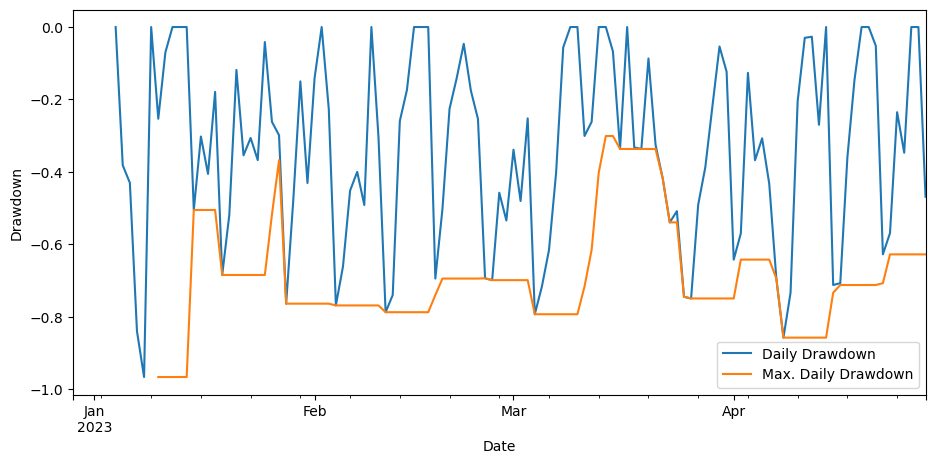

In [15]:
# We are going to use a trailing 1 trading day window
window = 7

# Calculate the max drawdown in the past window days for each day in the series.
Roll_Max = profits_df["Return Percent"].rolling(window).max()
Daily_Drawdown = profits_df["Return Percent"]/Roll_Max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown = Daily_Drawdown.rolling(window).min()

# Plot the results
Daily_Drawdown.plot(figsize=(11,5), label='Daily Drawdown')
Max_Daily_Drawdown.plot(figsize=(11,5), label='Max. Daily Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()

Both of these perform the same with no statistically significant deviation from each other.